(14031, 5)
        date    open    high     low   close
0 1971-01-04  0.5353  0.5353  0.5353  0.5353
1 1971-01-05  0.5350  0.5350  0.5350  0.5350
2 1971-01-06  0.5352  0.5352  0.5352  0.5352
3 1971-01-07  0.5353  0.5353  0.5353  0.5353
4 1971-01-08  0.5354  0.5354  0.5354  0.5354


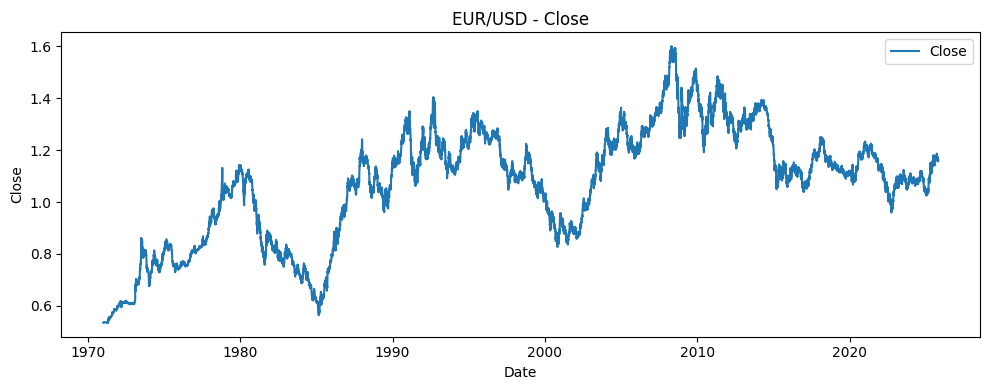

In [16]:
import sys, pathlib, importlib
import matplotlib.pyplot as plt

proj_root = pathlib.Path("..").resolve()
if str(proj_root) not in sys.path:
    sys.path.insert(0, str(proj_root))

import src.data_loading as dl
importlib.reload(dl)  # pour être sûr de prendre la version corrigée
df = dl.load_eurusd()

print(df.shape)
print(df.head())

plt.figure(figsize=(10, 4))
plt.plot(df["date"], df["close"], label="Close")
plt.title("EUR/USD - Close")
plt.xlabel("Date")
plt.ylabel("Close")
plt.legend()
plt.tight_layout()
plt.show()


Return moyen: 7.387171099178121e-05
Return std  : 0.0061291774091417365


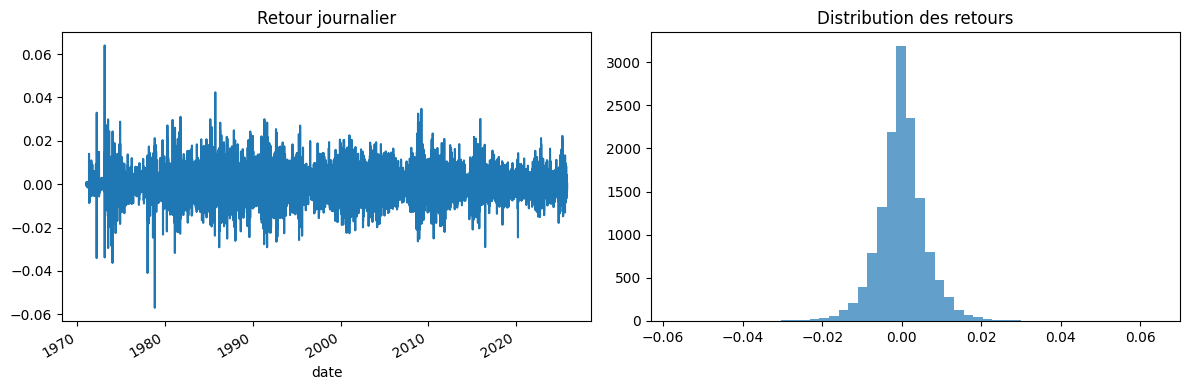

In [17]:
import matplotlib.pyplot as plt

df["ret"] = df["close"].pct_change()
print("Return moyen:", df["ret"].mean())
print("Return std  :", df["ret"].std())

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
df.set_index("date")["ret"].plot(ax=axes[0], title="Retour journalier")
axes[1].hist(df["ret"].dropna(), bins=50, color="tab:blue", alpha=0.7)
axes[1].set_title("Distribution des retours")
plt.tight_layout()
plt.show()


In [18]:
from src.features import add_features
from src.model_baseline import train_and_evaluate

df_feat = add_features(df)
model = train_and_evaluate(df_feat)  # imprime accuracy/ROC-AUC/confusion matrix


=== LogReg baseline ===
Accuracy: 0.49
ROC-AUC : 0.483
Confusion matrix:
 [[689 711]
 [720 685]]

Classification report:
               precision    recall  f1-score   support

           0      0.489     0.492     0.491      1400
           1      0.491     0.488     0.489      1405

    accuracy                          0.490      2805
   macro avg      0.490     0.490     0.490      2805
weighted avg      0.490     0.490     0.490      2805



In [19]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# Dummy: toujours la classe majoritaire observée dans le TRAIN
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)

acc_dummy = accuracy_score(y_test, y_pred_dummy)

print("=== Dummy (classe majoritaire) ===")
print("Accuracy:", round(acc_dummy, 3))

# ROC-AUC n'est pas défini ici car le dummy ne sort pas de probabilités utiles,
# tu peux éventuellement tester strategy='stratified' pour ça :
dummy_prob = DummyClassifier(strategy="stratified", random_state=0)
dummy_prob.fit(X_train, y_train)
y_proba_dummy = dummy_prob.predict_proba(X_test)[:, 1]
auc_dummy = roc_auc_score(y_test, y_proba_dummy)

print("ROC-AUC (stratified):", round(auc_dummy, 3))


=== Dummy (classe majoritaire) ===
Accuracy: 0.499
ROC-AUC (stratified): 0.494


In [20]:
from sklearn.ensemble import RandomForestClassifier
from src.evaluation import evaluate_classifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    random_state=0,
    n_jobs=-1
)

rf.fit(X_train, y_train)
evaluate_classifier(rf, X_train, y_train, X_test, y_test, name="RandomForest")


=== RandomForest ===
Accuracy: 0.488
ROC-AUC : 0.477
Confusion matrix:
 [[755 645]
 [790 615]]

Classification report:
               precision    recall  f1-score   support

           0      0.489     0.539     0.513      1400
           1      0.488     0.438     0.462      1405

    accuracy                          0.488      2805
   macro avg      0.488     0.489     0.487      2805
weighted avg      0.488     0.488     0.487      2805



(0.48841354723707664, 0.47670716827656323)